# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Path management

In [2]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.path.join(os.getcwd())

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# EDA

In [3]:
df_sample_submission = pd.read_csv(get_full_dir('input/playground-series-s3e15/sample_submission.csv'))
df_data = pd.read_csv(get_full_dir('input/playground-series-s3e15/data.csv'), index_col='id')
df_og = pd.read_csv(get_full_dir('input/predicting-heat-flux/Data_CHF_Zhao_2020_ATE.csv'), index_col='id')

In [4]:
df_data.isna().sum()

author                  5024
geometry                5500
pressure [MPa]          4452
mass_flux [kg/m2-s]     4791
x_e_out [-]            10415
D_e [mm]                5488
D_h [mm]                4589
length [mm]             4759
chf_exp [MW/m2]            0
dtype: int64

In [5]:
df_og.isna().sum()

author                 0
geometry               0
pressure [MPa]         0
mass_flux [kg/m2-s]    0
x_e_out [-]            0
D_e [mm]               0
D_h [mm]               0
length [mm]            0
chf_exp [MW/m2]        0
dtype: int64

##### Our training data contains lots of missing values, we could impute them using a very simple strategy like mean or median however this will likely result is poor model quality due to the about of missing value. Instead, we can also predict what value the missing value should have based off the other non-null value in these columns. The original data could be very he puff for that purpose since it does not contain any missing values.

In [6]:
df_sample_submission.head()

,id,x_e_out [-]
0,4,0.0
1,7,0.0
2,10,0.0
3,12,0.0
4,23,0.0


##### As describe in the completions we are prediction the missing values for x_e_out, our test data consist of all the row with missing x_e_out.

In [7]:
df_data.head()

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [8]:
df_og.head()

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


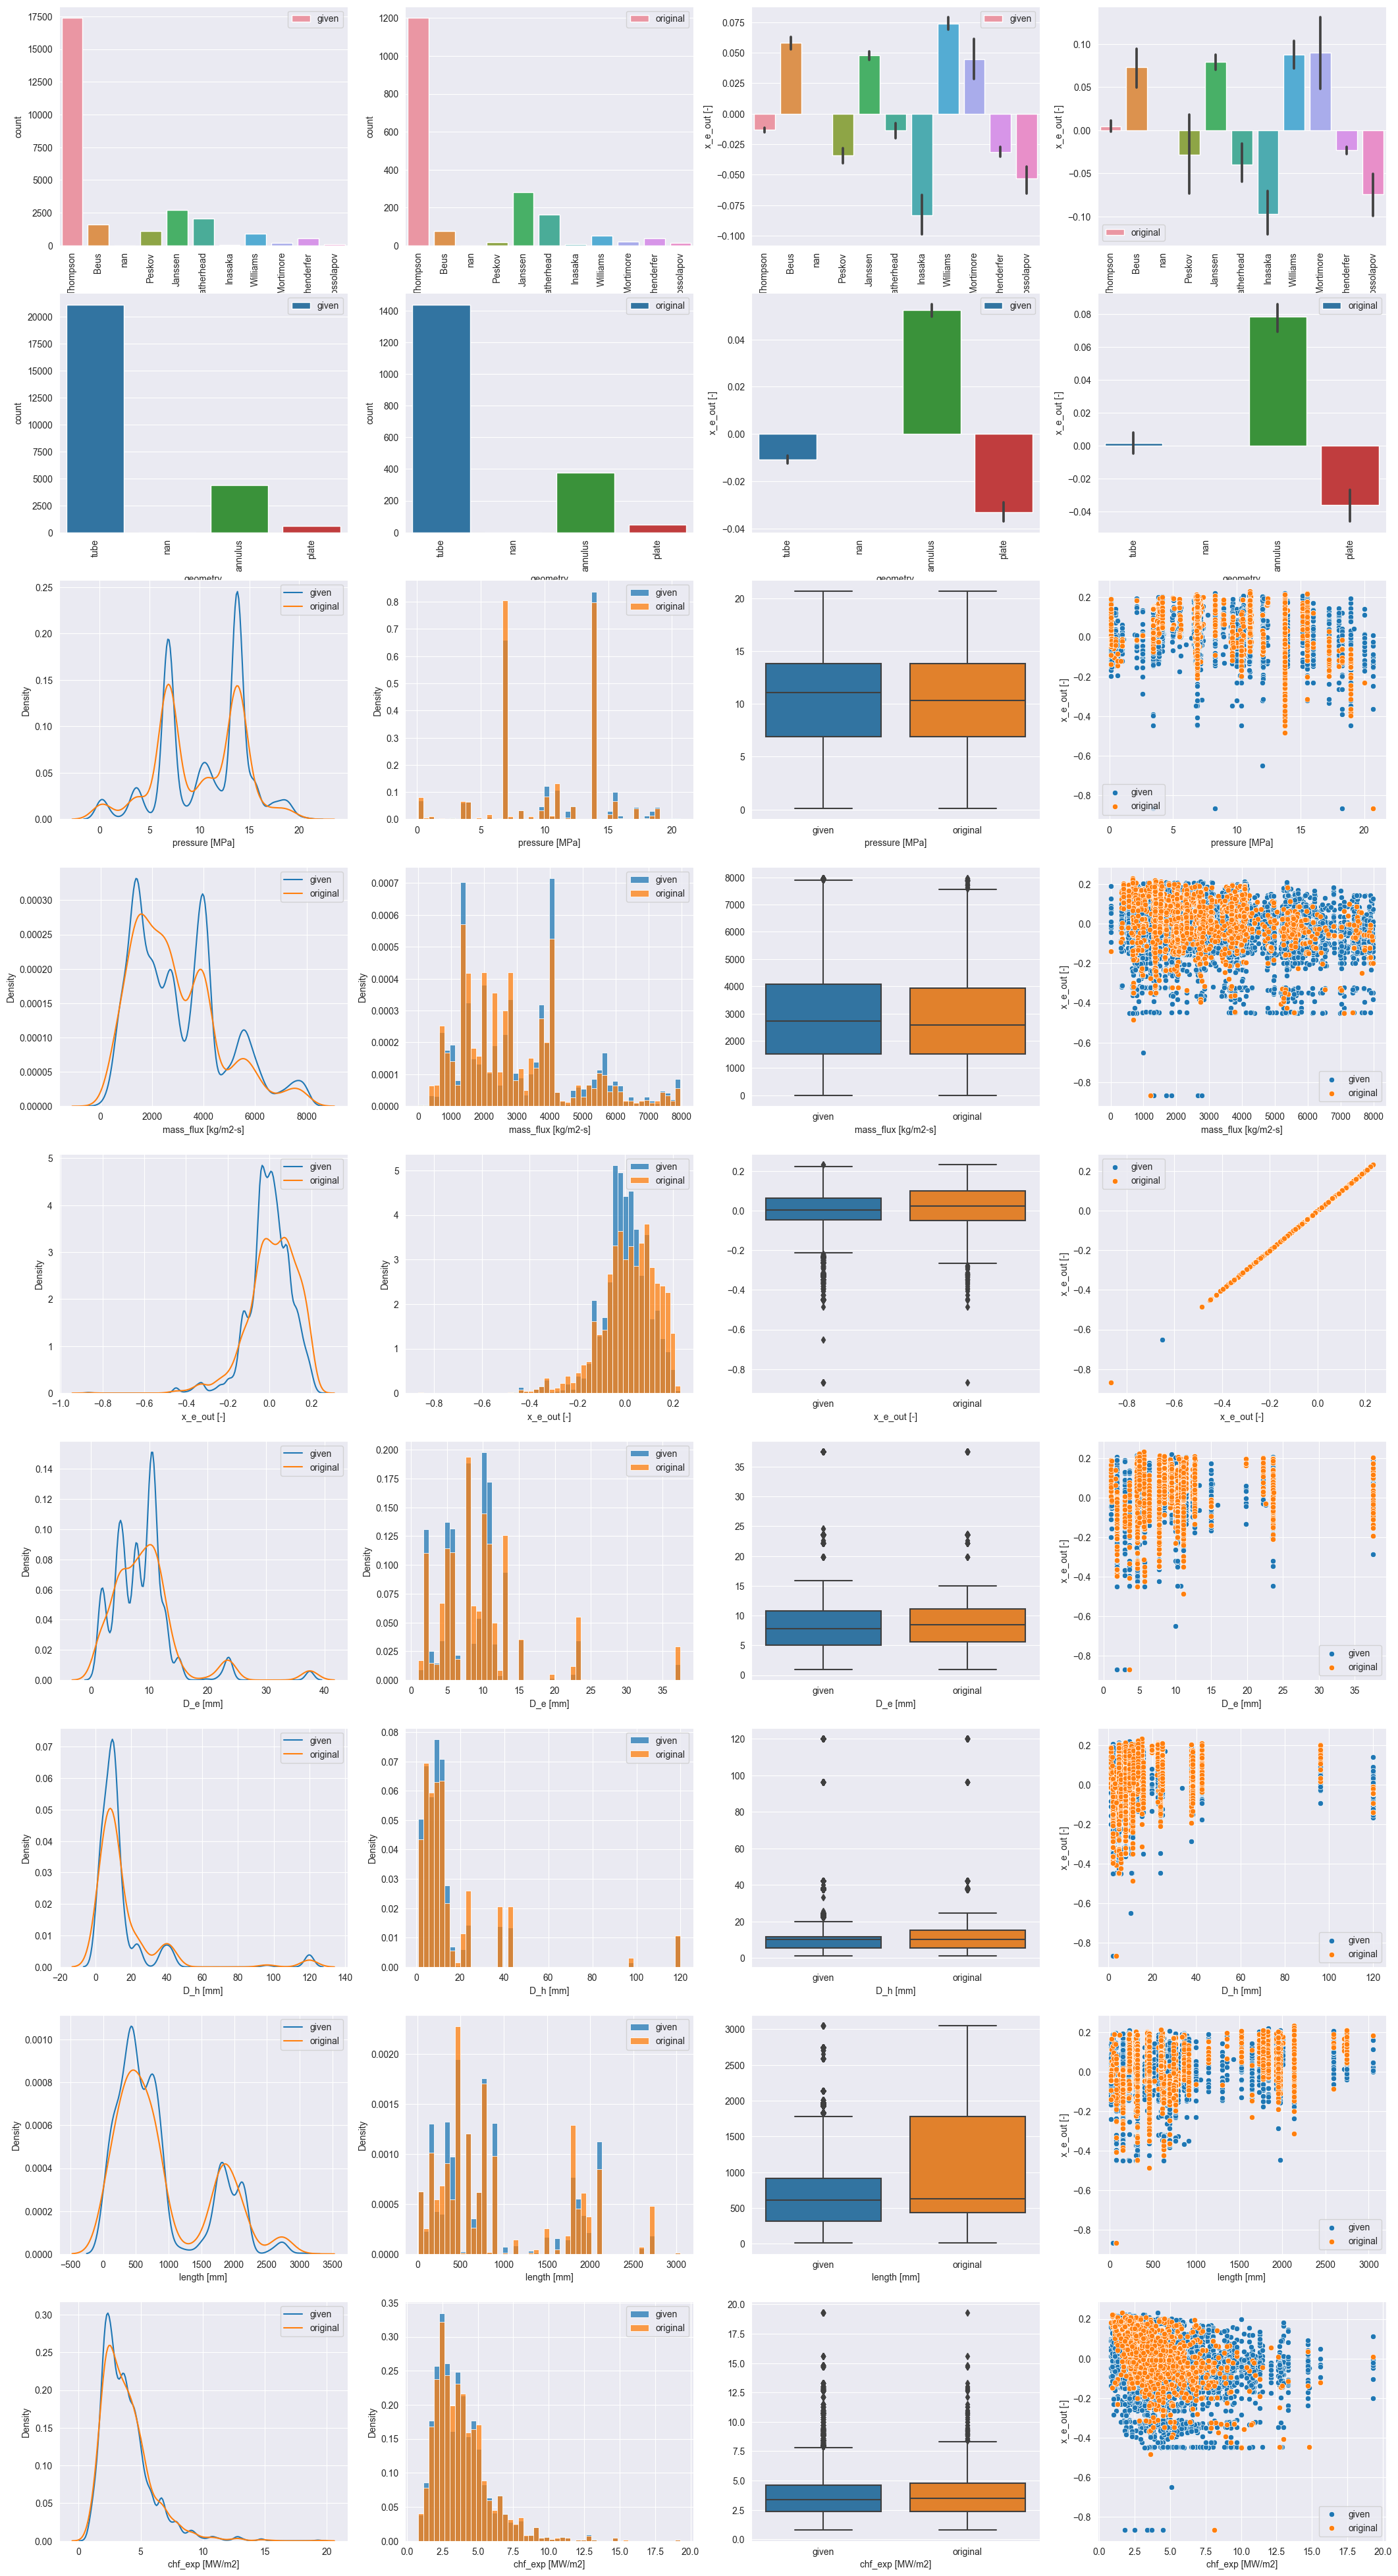

In [9]:
fig, axes = plt.subplots(nrows=len(df_data.columns), ncols=4, figsize=(26, 50))
axes = axes.flatten()

def graph_numerical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int) -> None:
    # Plot densities
    for df, column, label in data:
        sns.kdeplot(df[column], label=label, ax=axes[axes_start_i], fill=False)
    for df, column, label in data:
        sns.histplot(df[column], label=label, ax=axes[axes_start_i + 1], stat="density", bins=50)

    # Plot boxplot
    tmp_data_dict = {}
    for df, column, label in data:
        tmp_data_dict[label] = df[column]
    df_tmp = pd.DataFrame(tmp_data_dict)
    sns.boxplot(data=df_tmp, ax=axes[axes_start_i + 2])
    axes[axes_start_i + 2].set_xlabel(col)

    # Plot target correlation
    for df, column, label in data:
        sns.scatterplot(x=column, y=target, label=label, ax=axes[axes_start_i + 3], data=df)

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()
    axes[axes_start_i + 3].legend()

def graph_categorical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int) -> None:
    # Makes sure that the categories are shown in the same order
    category_order: list[str] = data[0][0][data[0][1]].unique()

    # Plot barplots
    for il, data_pack in enumerate(data):
        df, column, label = data_pack
        sns.countplot(x=column, data=df, label=label, order=category_order, ax=axes[axes_start_i + il])
        axes[axes_start_i + il].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

    # Plot target correlation
    for il, data_pack in enumerate(data):
        df, column, label = data_pack
        sns.barplot(x=column, y=target, data=df, label=label, order=category_order, ax=axes[axes_start_i + 2 + il])
        axes[axes_start_i + 2 + il].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()
    axes[axes_start_i + 2].legend()
    axes[axes_start_i + 3].legend()


i = 0
for col in df_data.columns:
    if pd.api.types.is_numeric_dtype(df_data[col]):
        graph_numerical_feature([(df_data, col, 'given'), (df_og, col, 'original')], 'x_e_out [-]', i)
    else:
        graph_categorical_feature([(df_data, col, 'given'), (df_og, col, 'original')], 'x_e_out [-]', i)
    i += 4

plt.show()

##### The original data closely follows the distribution of our given synthetic data. This suggesting the value where nulled in our given data set evenly across all features, this means that original data should be good to use without introduction feature or distribution bias.

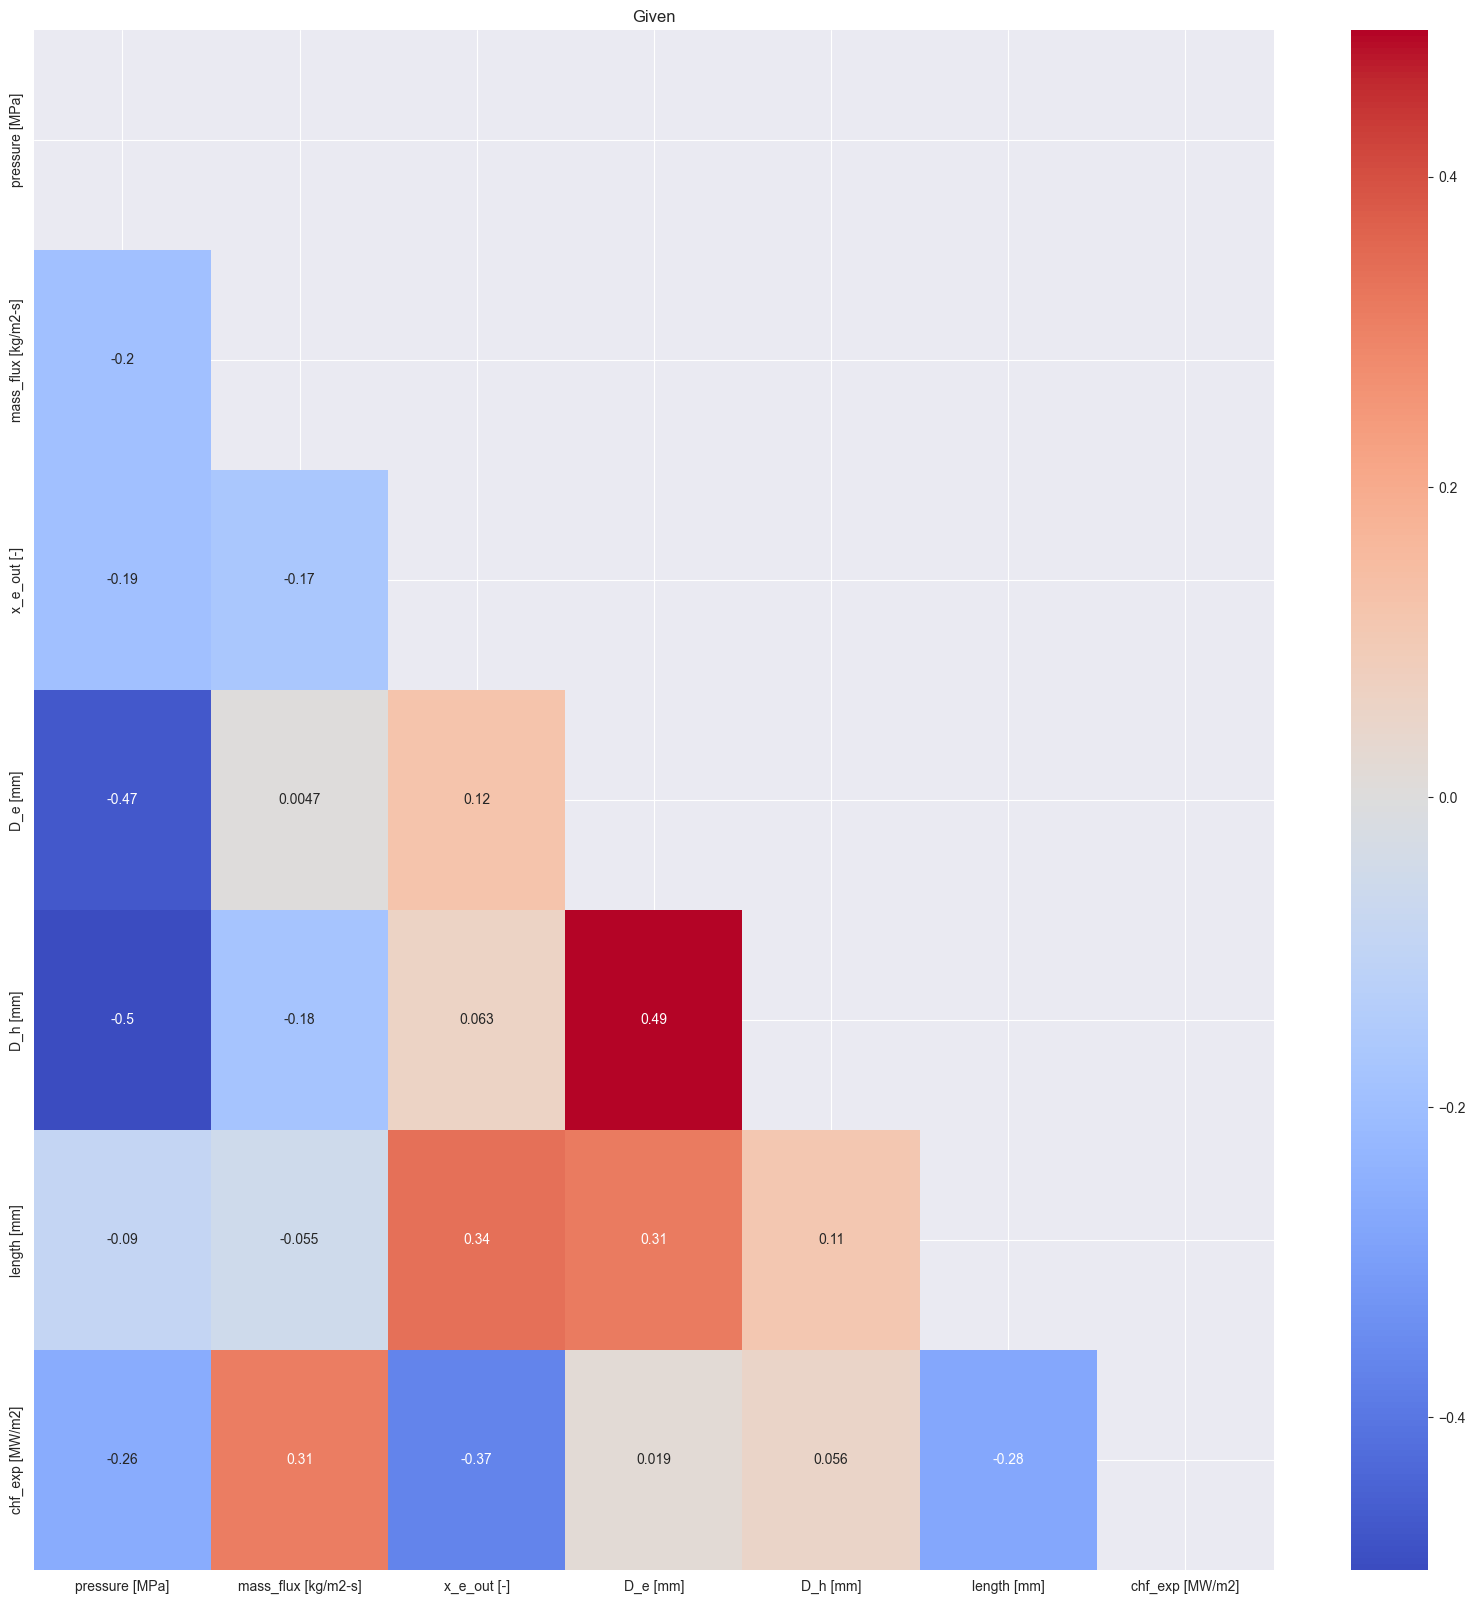

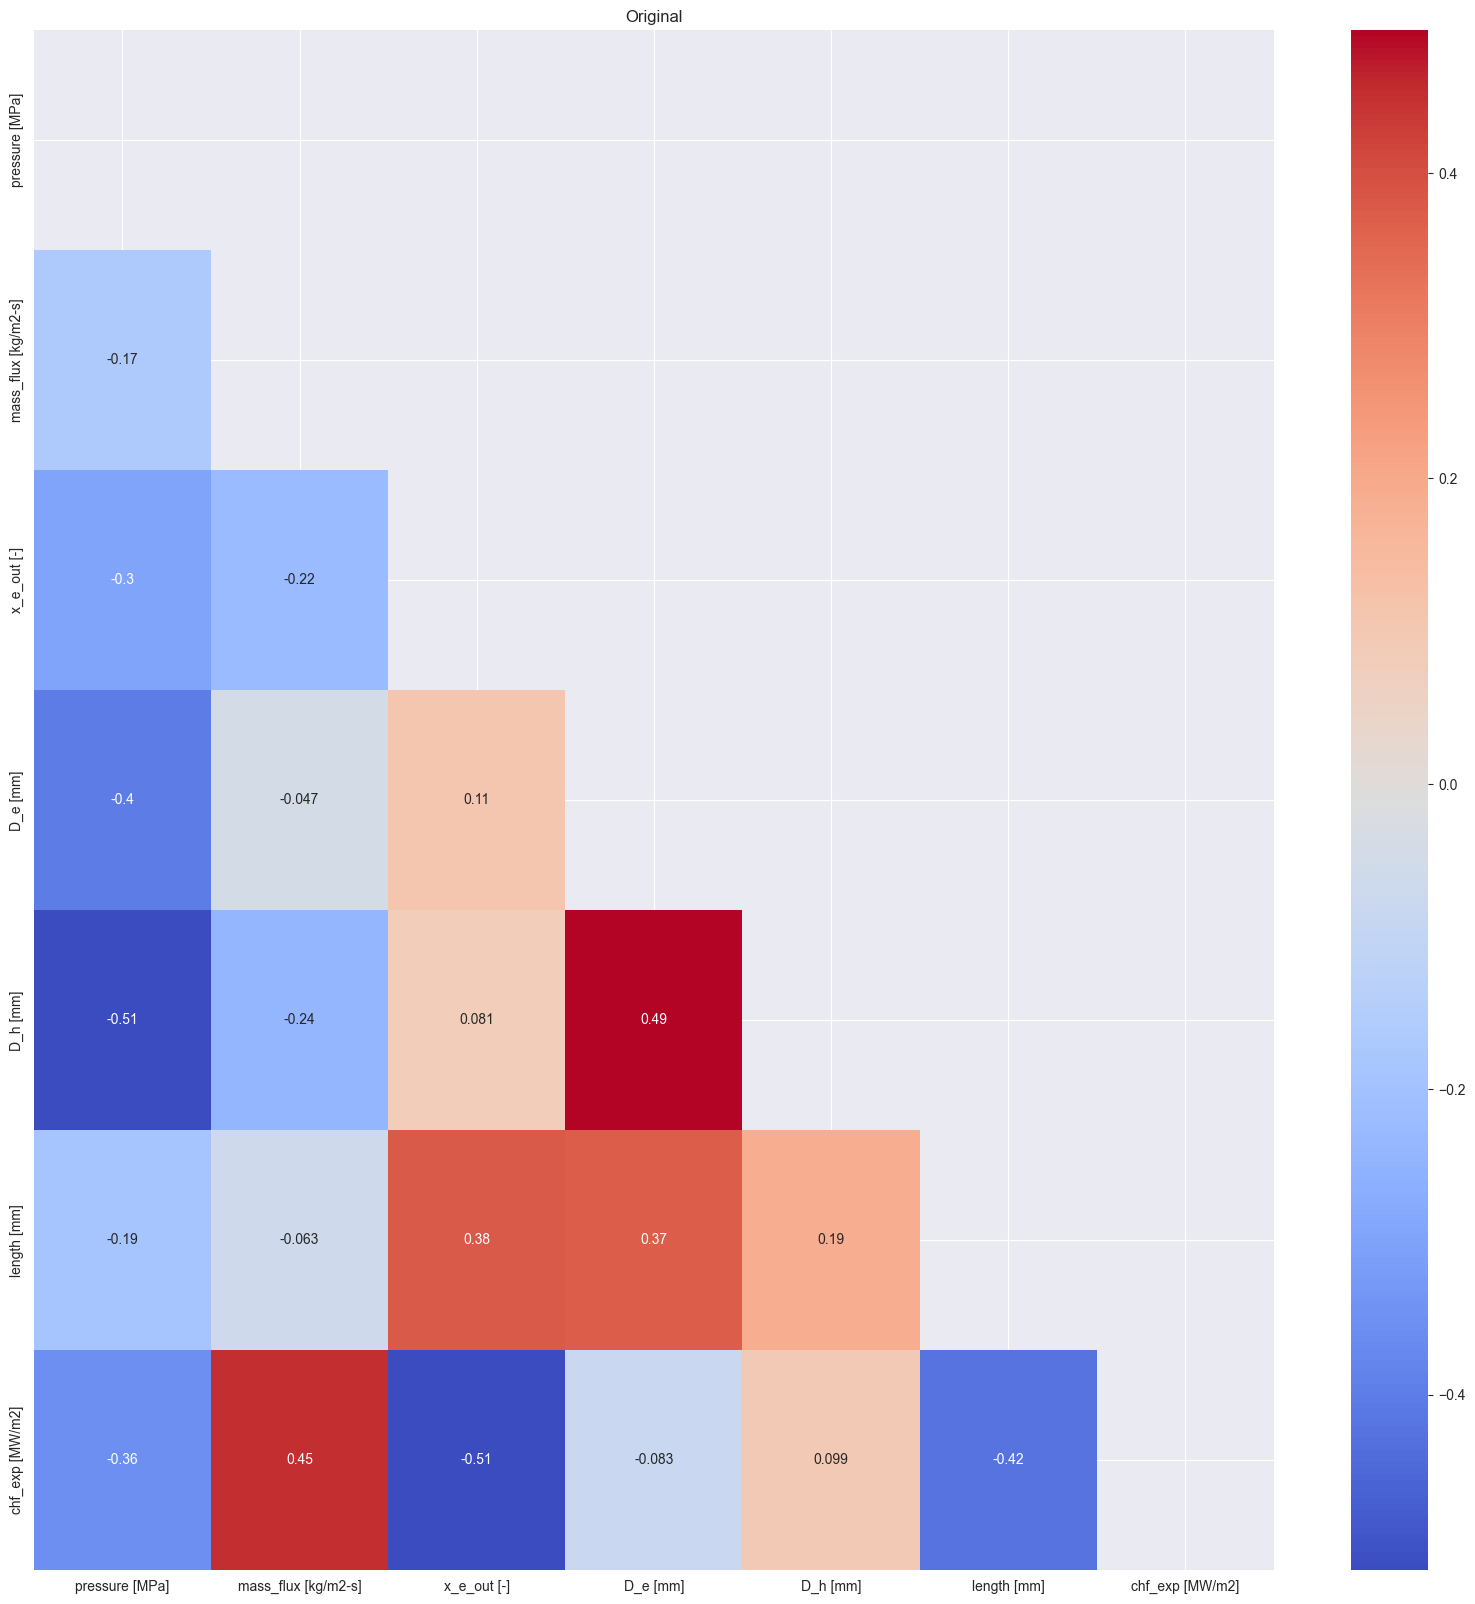

In [10]:
def show_feature_correlation(df: pd.DataFrame, title: str):
    plt.figure(figsize=(20, 20))
    corr_matrix = df.select_dtypes(include='number').corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, mask=mask)
    plt.title(title)
    plt.show()

show_feature_correlation(df_data, "Given")
show_feature_correlation(df_og, "Original")

# Data Prep

# Train